In [ ]:
!pip install torch pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 34.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, Predictive
from pyro.infer.autoguide import AutoDiagonalNormal
from torch.distributions import constraints
import numpy as np

In [ ]:
import pandas as pd

data = pd.read_csv('diabetes.csv')

In [ ]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = data.drop(columns=['Outcome'])
y = data['Outcome']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_clean, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
X_clean = torch.tensor(X_clean, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

# Add Noise

In [ ]:
def add_noise_to_data(X, noise_factor=0.8, outlier_fraction = 0.1, outlier_scale=5):
    noise = noise_factor * torch.randn_like(X)
    X_noisy = X + noise
    X_noisy = torch.clamp(X_noisy, 0, 1)

    num_outliers = int(outlier_fraction * X.shape[0])  # Determine number of outlier points
    outlier_indices = torch.randint(0, X.shape[0], (num_outliers,))  # Randomly select outlier positions
    X_outliers = torch.randn_like(X[outlier_indices]) * outlier_scale  # Scale up for extreme values
    X_noisy[outlier_indices] = X_outliers
    return X_noisy

X_train = add_noise_to_data(X_clean, noise_factor = 0.8, outlier_fraction=0.05)

In [ ]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([614, 8])
X_test shape: torch.Size([154, 8])
y_train shape: torch.Size([614])
y_test shape: torch.Size([154])


In [ ]:
pyro.clear_param_store()

In [ ]:
def model_MVN(X, y):
    w_prior = dist.MultivariateNormal(torch.zeros(X.shape[1]), torch.eye(X.shape[1]))  # Multivariate Normal for weights
    b_prior = dist.Normal(0., 1.)  # Normal prior for the bias

    # Sample weights and bias from the priors
    w = pyro.sample('w_MVN', w_prior)
    b = pyro.sample('b_MVN', b_prior)

    # Linear model: w * X + b
    logits = torch.matmul(X, w) + b
    probs = torch.sigmoid(logits)  # Sigmoid activation for binary classification

    # Likelihood: Bernoulli distribution for the binary target
    with pyro.plate('data', X.shape[0]):  # Plate to represent the batch dimension
        pyro.sample('obs', dist.Bernoulli(probs), obs=y)


def guide_MVN(X, y):
    # Define variational parameters for the weights and bias
    # Variational parameters for weights and bias
    w_loc = pyro.param('w_loc_MVN', torch.randn(X.shape[1]))  # Mean of variational distribution for weights
    w_scale = pyro.param('w_scale_MVN', torch.ones(X.shape[1]), constraint=torch.distributions.constraints.positive)  # Scale of variational distribution for weights
    b_loc = pyro.param('b_loc_MVN', torch.randn(1))  # Mean of variational distribution for bias
    b_scale = pyro.param('b_scale_MVN', torch.ones(1), constraint=torch.distributions.constraints.positive)  # Scale of variational distribution for bias

    # Variational distribution for the weights: Multivariate Normal
    # Using a diagonal covariance matrix for the variational distribution (for simplicity)
    w_cov = torch.diag(w_scale)  # Covariance matrix for the variational distribution
    pyro.sample('w_MVN', dist.MultivariateNormal(w_loc, w_cov))  # Multivariate Normal for weights

    # Variational distribution for the bias
    pyro.sample('b_MVN', dist.Normal(b_loc, b_scale))  # Normal for bias


# Optimizer setup
adam_params = {"lr": 0.01}
optimizer = pyro.optim.Adam(adam_params)

# SVI setup
svi_MVN = SVI(model_MVN, guide_MVN, optimizer, loss=Trace_ELBO())

# Train the model with Stochastic Variational Inference (SVI)
num_steps = 5000
for step in range(num_steps):
    loss = svi_MVN.step(X_train, y_train)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss}")


Step 0, Loss: 465.79651087522507
Step 100, Loss: 573.5074291229248
Step 200, Loss: 490.50704738497734
Step 300, Loss: 427.19831651449203
Step 400, Loss: 519.4589389562607
Step 500, Loss: 444.7797906398773
Step 600, Loss: 468.0803437232971
Step 700, Loss: 440.75920271873474
Step 800, Loss: 468.35465145111084
Step 900, Loss: 455.0149943828583
Step 1000, Loss: 418.1747044324875
Step 1100, Loss: 405.77051079273224
Step 1200, Loss: 404.4977397918701
Step 1300, Loss: 413.8839374780655
Step 1400, Loss: 415.1935005187988
Step 1500, Loss: 405.3728417158127
Step 1600, Loss: 405.1614501476288
Step 1700, Loss: 402.1953845024109
Step 1800, Loss: 402.3979939222336
Step 1900, Loss: 405.39938247203827
Step 2000, Loss: 405.22843039035797
Step 2100, Loss: 399.06202733516693
Step 2200, Loss: 405.0313481092453
Step 2300, Loss: 401.5355695486069
Step 2400, Loss: 401.548641204834
Step 2500, Loss: 404.5765804052353
Step 2600, Loss: 405.2049711942673
Step 2700, Loss: 404.37067198753357
Step 2800, Loss: 402.99

In [ ]:
def model_T(X, y):
    # Define priors with separate degrees of freedom
    df_w = pyro.sample("df_w", dist.Gamma(2.0, 1.0))
    df_b = pyro.sample("df_b", dist.Gamma(2.0, 1.0))

    w_prior = dist.StudentT(df=df_w, loc=torch.zeros(X.shape[1]), scale=torch.ones(X.shape[1]))
    b_prior = dist.StudentT(df=df_b, loc=torch.zeros(1), scale=torch.ones(1))

    # Sample weights and bias from the priors
    w = pyro.sample('w_T', w_prior.to_event(1))
    b = pyro.sample('b_T', b_prior)

    # Linear model: w * X + b
    logits = torch.matmul(X, w) + b
    probs = torch.sigmoid(logits)

    # Likelihood: Bernoulli distribution for the binary target
    with pyro.plate('data', X.shape[0]):
        pyro.sample('obs', dist.Bernoulli(probs), obs=y)


def guide_T(X, y):
    # Define separate variational parameters for degrees of freedom
    df_w_loc = pyro.param("df_w_loc", torch.tensor(2.0), constraint=dist.constraints.positive)
    df_b_loc = pyro.param("df_b_loc", torch.tensor(2.0), constraint=dist.constraints.positive)

    # Define variational parameters for weights and bias
    w_loc = pyro.param('w_loc_T', torch.randn(X.shape[1]))
    w_scale = pyro.param('w_scale_T', torch.ones(X.shape[1]), constraint=dist.constraints.positive)

    b_loc = pyro.param('b_loc_T', torch.randn(1))
    b_scale = pyro.param('b_scale_T', torch.ones(1), constraint=dist.constraints.positive)

    # Sample from variational distributions
    pyro.sample("df_w", dist.Gamma(df_w_loc, torch.tensor(1.0)))
    pyro.sample("df_b", dist.Gamma(df_b_loc, torch.tensor(1.0)))

    pyro.sample('w_T', dist.StudentT(df=df_w_loc, loc=w_loc, scale=w_scale).to_event(1))
    pyro.sample('b_T', dist.StudentT(df=df_b_loc, loc=b_loc, scale=b_scale))


# Optimizer setup
adam_params = {"lr": 0.01}
optimizer = pyro.optim.Adam(adam_params)

# SVI setup
svi_T = SVI(model_T, guide_T, optimizer, loss=Trace_ELBO())

# Training loop
num_steps = 5000
for step in range(num_steps):
    loss = svi_T.step(X_train, y_train)
    if step % 100 == 0:
        print(f"Step {step}, Loss: {loss}")

Step 0, Loss: 1044.4411659240723
Step 100, Loss: 782.862062394619
Step 200, Loss: 514.37712931633
Step 300, Loss: 613.0065019130707
Step 400, Loss: 439.05280746519566
Step 500, Loss: 414.34810706973076
Step 600, Loss: 404.25248370319605
Step 700, Loss: 415.9367492198944
Step 800, Loss: 436.9714376926422
Step 900, Loss: 404.91847386956215
Step 1000, Loss: 405.90275543928146
Step 1100, Loss: 413.0761631131172
Step 1200, Loss: 410.42171597480774
Step 1300, Loss: 406.774841606617
Step 1400, Loss: 410.067715883255
Step 1500, Loss: 408.74067348241806
Step 1600, Loss: 400.7225783765316
Step 1700, Loss: 404.67474776506424
Step 1800, Loss: 399.63579189777374
Step 1900, Loss: 402.77087473869324
Step 2000, Loss: 410.1599823832512
Step 2100, Loss: 402.66305577754974
Step 2200, Loss: 404.59928011894226
Step 2300, Loss: 404.18248188495636
Step 2400, Loss: 402.1482108235359
Step 2500, Loss: 401.12092983722687
Step 2600, Loss: 403.33267241716385
Step 2700, Loss: 401.55121272802353
Step 2800, Loss: 403

In [ ]:
T_df_w_param = pyro.param("df_w_loc").detach().item()
T_df_b_param = pyro.param("df_b_loc").detach().item()

T_scale_param_tensor = pyro.param('w_scale_T').detach()
T_mean_param_tensor = pyro.param('w_loc_T').detach()
T_bias_mean_param = pyro.param('b_loc_T').detach()
T_bias_scale_param = pyro.param('b_scale_T').detach()

MVN_scale_param_tensor = pyro.param('w_scale_MVN').detach()
MVN_mean_param_tensor = pyro.param('w_loc_MVN').detach()
MVN_bias_mean_param = pyro.param('b_loc_MVN').detach()
MVN_bias_scale_param = pyro.param('b_scale_MVN').detach()
r = np.diag(T_scale_param_tensor.numpy())

In [ ]:
r.shape

(8, 8)

In [ ]:
vi_posterior_t = [dist.StudentT(pyro.param("df_w_loc").detach().item(), pyro.param('w_loc_T').detach()[i], pyro.param('w_scale_T').detach()[i])for i in range(8)]
vi_posterior = dist.MultivariateNormal(loc = pyro.param('w_loc_MVN').detach(), covariance_matrix= torch.diag(pyro.param('w_scale_MVN').detach()))

# Pseudo BMA and Stacking for optimal weights

In [ ]:
import arviz as az
import pymc as pm

In [ ]:
rng = np.random.seed(2741)

In [ ]:
# Model 1: Multivariate Normal
with pm.Model() as model_mvnorm:
    # Priors (extracting from vi_posterior)
    intercept = pm.Normal('intercept', mu= MVN_bias_mean_param.numpy()[0], sigma= MVN_bias_scale_param.numpy()[0])
    coefs = pm.MvNormal('coefs', mu=vi_posterior.loc[0:].numpy(), cov=vi_posterior.covariance_matrix[:, :].numpy())


    # Logistic regression
    logits = pm.invlogit(intercept + pm.math.dot(X_train.numpy(), coefs))
    likelihood = pm.Bernoulli('likelihood', logit_p=logits, observed=y_train.numpy())

    idata_0 = pm.sample(draws=2000, tune=1000, target_accept=0.99, idata_kwargs={"log_likelihood": True}, random_seed=rng)
    pm.sample_posterior_predictive(idata_0, extend_inferencedata=True, random_seed=rng)

Output()

Output()

array([[<Axes: title={'center': 'coefs'}>,
        <Axes: title={'center': 'coefs'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>]], dtype=object)

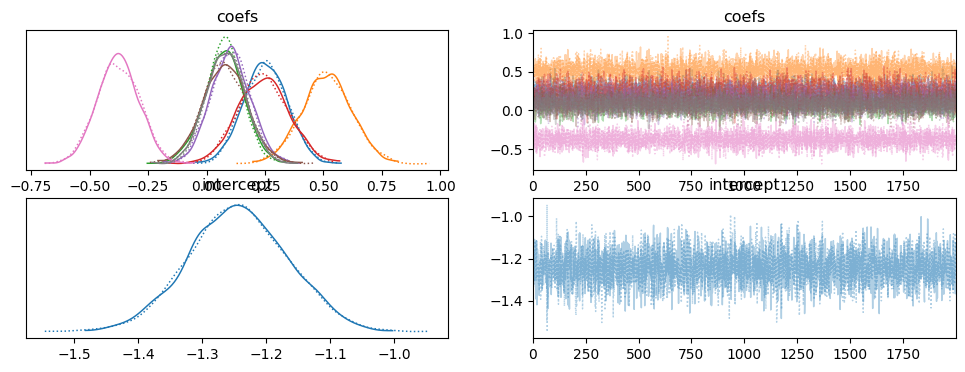

In [ ]:
pm.plot_trace(idata_0)

In [ ]:
# Model 2: Student T
with pm.Model() as model_studentt:
    # Priors (extracting from vi_posterior_t)
    intercept = pm.StudentT('intercept', mu= T_bias_mean_param.numpy()[0], sigma= T_bias_scale_param.numpy()[0], nu=T_df_b_param)
    coefs = pm.MvStudentT("coefs",mu=T_mean_param_tensor.numpy(),scale=r,nu=T_df_w_param)

    # Logistic regression
    logits = pm.invlogit(intercept + pm.math.dot(X_train.numpy(), coefs))
    likelihood = pm.Bernoulli('likelihood', logit_p=logits, observed=y_train.numpy())

    idata_1 = pm.sample(draws=2000, tune=1000, target_accept=0.99, idata_kwargs={"log_likelihood": True}, random_seed=rng)
    pm.sample_posterior_predictive(idata_1, extend_inferencedata=True, random_seed=rng)


Output()

Output()

array([[<Axes: title={'center': 'coefs'}>,
        <Axes: title={'center': 'coefs'}>],
       [<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'intercept'}>]], dtype=object)

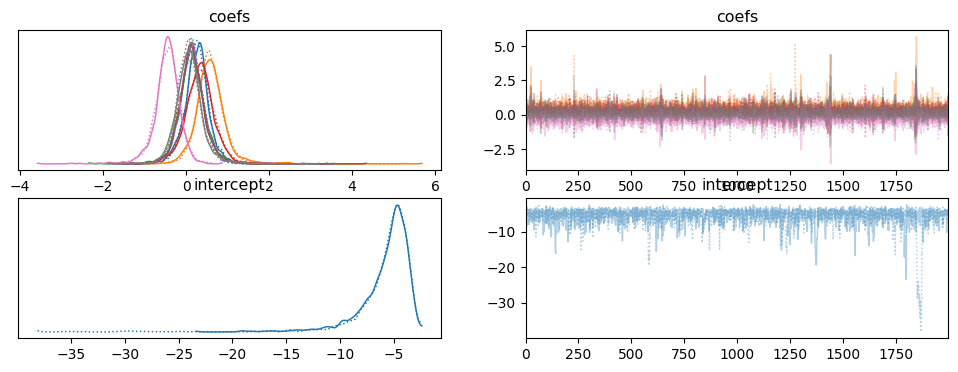

In [ ]:
pm.plot_trace(idata_1)

In [ ]:
model_dict = dict(zip(["model_mvnorm", "model_studentt"], [idata_0, idata_1]))
comp = az.compare(model_dict, method = "stacking")
comp

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_studentt,0,-426.499282,0.500013,0.000000,1.000000e+00,0.51537,0.000000,True,log
model_mvnorm,1,-453.160660,0.350046,26.661378,4.291678e-12,3.65225,3.338716,False,log


# Test Accuracy

In [ ]:
def predict_testset(X, num_samples=4000, w1=comp.loc['model_studentt', 'weight'], w2=comp.loc['model_mvnorm', 'weight']):
    # Student-T parameters (separate df for weights and bias)
    df_w = T_df_w_param
    df_b = T_df_b_param
    w_loc_T = pyro.param('w_loc_T')
    w_scale_T = pyro.param('w_scale_T')
    b_loc_T = pyro.param('b_loc_T')
    b_scale_T = pyro.param('b_scale_T')

    # MVN parameters
    w_loc_MVN = pyro.param('w_loc_MVN')
    w_cov_MVN = torch.diag(pyro.param('w_scale_MVN'))
    b_loc_MVN = pyro.param('b_loc_MVN')
    b_scale_MVN = pyro.param('b_scale_MVN')

    # Sample mixture components
    mix_component = torch.bernoulli(torch.full((num_samples,), w1))  # Choose component
    mix_component_copy = mix_component.clone()

    # Sample weights from mixture
    w_samples_T = dist.StudentT(df=df_w, loc=w_loc_T, scale=w_scale_T).sample((num_samples,))
    w_samples_MVN = dist.MultivariateNormal(w_loc_MVN, w_cov_MVN).sample((num_samples,))
    w_samples = torch.where(
        mix_component[:, None] == 1,
        w_samples_T,
        w_samples_MVN
    )

    # Sample biases from mixture
    b_samples_T = dist.StudentT(df=df_b, loc=b_loc_T, scale=b_scale_T).sample((num_samples,))
    b_samples_MVN = dist.Normal(b_loc_MVN, b_scale_MVN).sample((num_samples,))
    b_samples = torch.where(mix_component_copy[:, None] == 1, b_samples_T, b_samples_MVN)

    # Compute logits and average prediction
    logits = torch.matmul(X, w_samples.T) + b_samples.T
    probs = torch.sigmoid(logits).mean(dim=1)

    return (probs > 0.5).float()

In [ ]:
y_pred = predict_testset(X_test)
accuracy = (y_pred == y_test).float().mean()
print(f"Accuracy: {accuracy.item() * 100:.4f}%")

Accuracy: 68.1818%


In [ ]:
def predict(X, num_samples = 4000):
    # Get the learned parameters from the guide
    w_loc = pyro.param('w_loc_MVN')  # Mean of the weights
    w_cov = torch.diag(pyro.param('w_scale_MVN'))  # Covariance of the weights (diagonal for simplicity)
    b_loc = pyro.param('b_loc_MVN')  # Mean of the bias
    b_scale = pyro.param('b_scale_MVN')  # Std dev of the bias
    prob_samples = []
    for i in range(num_samples):
        # Sample from the variational distribution of w and b (posterior predictive sampling)
        w = dist.MultivariateNormal(w_loc, w_cov).sample()  # Sample weights
        b = dist.Normal(b_loc, b_scale).sample()  # Sample bias

        # Make predictions using the logistic model
        logits = torch.matmul(X, w) + b
        probs = torch.sigmoid(logits)
        prob_samples.append(probs)
    prob_samples = torch.stack(prob_samples)
    probs = prob_samples.mean(dim=0)
    return (probs > 0.5).float()  # Return binary predictions

# Predict on test data
y_pred_MVN = predict(X_test)

# Evaluate accuracy
accuracy = (y_pred_MVN == y_test).float().mean()
print(f"Accuracy: {accuracy.item() * 100:.4f}%")

Accuracy: 71.4286%
